In [3]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 1. Load Dataset
# -----------------------------
df = pd.read_csv("Airline_Delay_Cause.csv")
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

Dataset Shape: (26440, 21)
Columns: Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')


In [5]:
print("\nMissing Values Before:\n", df.isnull().sum())


Missing Values Before:
 year                    0
month                   0
carrier                 0
carrier_name            0
airport                 0
airport_name            0
arr_flights            11
arr_del15              14
carrier_ct             11
weather_ct             11
nas_ct                 11
security_ct            11
late_aircraft_ct       11
arr_cancelled          11
arr_diverted           11
arr_delay              11
carrier_delay          11
weather_delay          11
nas_delay              11
security_delay         11
late_aircraft_delay    11
dtype: int64


In [6]:
# Strategy:
# - Numeric columns → fill with mean
# - Categorical columns → fill with mode

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].mean(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing Values After:\n", df.isnull().sum())


Missing Values After:
 year                   0
month                  0
carrier                0
carrier_name           0
airport                0
airport_name           0
arr_flights            0
arr_del15              0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
dtype: int64


C:\Users\Tejas Pund\AppData\Local\Temp\ipykernel_23708\1930257755.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\Tejas Pund\AppData\Local\Temp\ipykernel_23708\1930257755.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [7]:
# 3. Basic EDA
# -----------------------------

# Avg delay per airline
avg_delay_airline = df.groupby("carrier_name")["arr_delay"].mean().sort_values(ascending=False)
print("\nAverage Delay by Airline:\n", avg_delay_airline)


Average Delay by Airline:
 carrier_name
American Airlines Network                  13970.681685
Southwest Airlines                         12087.503739
Delta Air Lines Network                     7828.734704
United Air Lines Network                    7755.092421
JetBlue Airways                             5811.247972
Spirit Airlines                             5376.678230
Frontier Airlines                           4785.969991
PSA Airlines Inc.                           4682.531524
SkyWest Airlines Inc.                       4196.853478
Republic Airline                            3560.725589
Endeavor Air Inc.                           2551.309091
Alaska Airlines Network                     2493.429280
Piedmont Airlines                           2396.814025
Envoy Air                                   2222.138454
Hawaiian Airlines Network                   2111.508197
GoJet Airlines LLC d/b/a United Express     2075.344730
Air Wisconsin Airlines Corp                 1905.665535
Commute

In [8]:
# Airport-wise delay
avg_delay_airport = df.groupby("airport_name")["arr_delay"].mean().sort_values(ascending=False)
print("\nAverage Delay by Airport:\n", avg_delay_airport)


Average Delay by Airport:
 airport_name
Dallas/Fort Worth, TX: Dallas/Fort Worth International              47057.497006
Denver, CO: Denver International                                    36744.944056
Chicago, IL: Chicago O'Hare International                           31936.257282
Atlanta, GA: Hartsfield-Jackson Atlanta International               28976.700508
Charlotte, NC: Charlotte Douglas International                      28290.229947
                                                                        ...     
Santa Maria, CA: Santa Maria Public/Capt. G. Allan Hancock Field      145.428571
Pago Pago, TT: Pago Pago International                                142.785714
Saipan, TT: Francisco C. Ada Saipan International                     132.142857
Adak Island, AK: Adak                                                  49.285714
St. Cloud, MN: St. Cloud Regional                                      25.000000
Name: arr_delay, Length: 360, dtype: float64


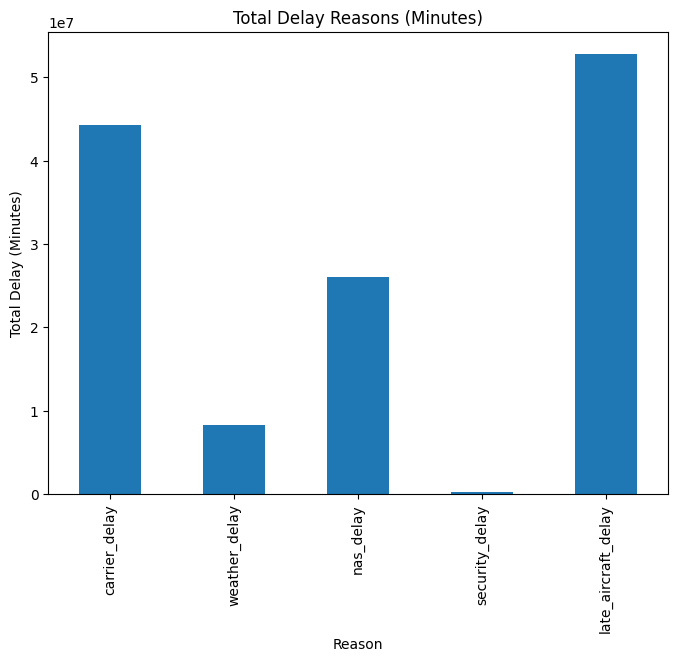

In [9]:
# Visualization - Delay reasons distribution
plt.figure(figsize=(8,6))
delay_cols = ["carrier_delay","weather_delay","nas_delay","security_delay","late_aircraft_delay"]
df[delay_cols].sum().plot(kind="bar")
plt.title("Total Delay Reasons (Minutes)")
plt.xlabel("Reason")
plt.ylabel("Total Delay (Minutes)")
plt.show()

In [10]:
# 4. MySQL Connection
# -----------------------------
username = "root"   
password = "Tejas" 
host = "localhost"
database = "airline_delay"

# SQLAlchemy engine
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}/{database}")

df.to_sql("airline_delays", con=engine, if_exists="replace", index=False)
print("✅ Data Imported Successfully into MySQL!")

✅ Data Imported Successfully into MySQL!


In [14]:
def get_data_from_sql():
    return pd.read_sql("SELECT * FROM airline_delays", con=engine)
def update_sql_from_pandas(df):
    df.to_sql("airline_delays", con=engine, if_exists="replace", index=False)

In [ ]:
import time

def auto_sync(interval=10):
    global df_cache

    print("🔄 Auto Sync Started (every", interval, "seconds)...")
    df_cache = get_data_from_sql()

    while True:
        time.sleep(interval)

        df_latest = get_data_from_sql()
        if not df_latest.equals(df_cache):
            print("⚡ SQL changed → refreshing Pandas DataFrame")
            df_cache = df_latest.copy()

        if not df_cache.equals(df_latest):
            print("⚡ Pandas changed → updating SQL")
            update_sql_from_pandas(df_cache)

# Run Auto Sync
# -------------------------------
if __name__ == "__main__":
    auto_sync(interval=15)  

🔄 Auto Sync Started (every 15 seconds)...


KeyboardInterrupt: 